In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image

In [3]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"

In [4]:
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()

In [5]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [6]:

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    job0 = jobs[0]
    dfs = []
    for job in jobs:
        for file in sorted(glob.glob(job.fn("short_runs/temp-0.47/sfs.parquet"))):
            temp = float(utils.extract_between(file, "temp-", "/sfs.parquet"))
            df = pd.read_parquet(file)
            df = df[df["type"] == 0]

            df["softness"] = pipe.decision_function(list(df["sf"]))
            dfs.append(df)
        break
    df = pd.concat(dfs)
    break

0.0


In [7]:
df.head()

,frame,tag,type,phop,sf,softness
1,0,1,0,0.007798,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0054128096, 0.0023...",-0.094140
2,0,2,0,0.002343,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.043865047, 0.0, 0....",-0.660533
3,0,3,0,0.001911,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0023834414, 0...",-1.172910
4,0,4,0,0.004497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002481542, 0....",0.116736
5,0,5,0,0.002575,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002920351, 0....",-0.542855


In [8]:
tdf = df[df.frame == 0]

In [9]:
len(tdf)

26215

In [10]:
tdf

,frame,tag,type,phop,sf,softness
1,0,1,0,0.007798,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0054128096, 0.0023...",-0.094140
2,0,2,0,0.002343,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.043865047, 0.0, 0....",-0.660533
3,0,3,0,0.001911,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0023834414, 0...",-1.172910
4,0,4,0,0.004497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002481542, 0....",0.116736
5,0,5,0,0.002575,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002920351, 0....",-0.542855
...,...,...,...,...,...,...
32762,0,32762,0,0.006253,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.010926092, 0.00245...",-0.699566
32763,0,32763,0,0.004294,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.019768868, 0.0, 0....",-0.515669
32764,0,32764,0,0.002103,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.021552442, 0.0, 0....",-0.442615
32765,0,32765,0,0.005100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.04971496, 0.0, 0.5...",-0.436601


In [11]:
@njit
def excess_entropy(r, g, dr):
    prelim = (g*np.log(g)-g+1)*r*r*dr
    prelim[np.isnan(prelim)] = 0
    return -2.0*np.pi*np.sum(prelim)

@njit
def local_excess_entropy(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        sf = sfs[i,::2] + sfs[i,1::2]
        inv_n = 1/np.sum(sf)
        g = sf*inv_shell*inv_n*vol
        out[i] = excess_entropy(r, g, dr)
    return out

@njit
def local_excess_entropy_binary(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol
        out[i] = na/n*excess_entropy(r, g_a, dr) + nb/n*excess_entropy(r, g_b, dr)
    return out

@njit
def local_excess_entropy_density(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        sf = sfs[i,::2] + sfs[i,1::2]
        inv_n = 1/np.sum(sf)
        g = sf*inv_shell*inv_n*vol
        out[i] = excess_entropy(r, g, dr)/vol/inv_n
    return out


@njit
def local_excess_entropy_binary_density(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol
        out[i] = (na/n*excess_entropy(r, g_a, dr) + nb/n*excess_entropy(r, g_b, dr))*n/vol
    return out

def local_rdf_binary_density(r, sf, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    na = np.sum(sf[::2])
    nb = np.sum(sf[1::2])
    n = na + nb
    inv_na = 1/na
    inv_nb = 1/nb
    g_a = sf[::2]*inv_shell*inv_na*vol
    g_b = sf[1::2]*inv_shell*inv_nb*vol
    return (g_a, g_b)

@njit
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

@njit
def local_excess_entropy_binary_density_var(r, sfs, dr, alpha=0.5, taper=(2.0, 1.0)):
    if not (alpha <= 1.0 and alpha >= 0.0):
        raise ValueError("alpha must be between 0 and 1")
    alpha_n = 1 - alpha
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    log_taper = sigmoid((r - taper[0])/taper[1])
    nlt = 1 - log_taper
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol*nlt + log_taper
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol*nlt + log_taper
        out[i] = (alpha*na/n*excess_entropy(r, g_a, dr) + alpha_n*nb/n*excess_entropy(r, g_b, dr))*n/vol
    return out


In [13]:
def compute_s2(df, groups):
    s2 = []
    r = np.linspace(0.4, 3.0, 27)
    dr = r[1] - r[0]
    N = 0
    for group in groups:
        sf = df.iloc[group].sf.mean()
        N += len(group)
        s2.append(local_excess_entropy_binary_density(r, np.array([sf]), dr)*len(group))

    s2 = -np.sum([x/N for x in s2])
        
    return s2

def compute_s2_sub(df, groups):
    s2 = []
    r = np.linspace(0.4, 3.0, 27)
    dr = r[1] - r[0]
    N = 0
    for group in groups:
        sf = df.iloc[group].sf.mean()
        N += len(group)
        s2.append(local_excess_entropy_binary_density(r, np.array([sf]), dr))

    s2 = [-x for x in s2]
        
    return s2

def compute_rdf(df, groups):
    s2 = []
    r = np.linspace(0.4, 3.0, 27)
    dr = r[1] - r[0]
    N = 0
    for group in groups:
        print(group)
        sf = df.iloc[group].sf.mean()
        N += len(group)
        s2.append(local_rdf_binary_density(r, sf, dr))
        
    return s2

def new_groups(groups):
    new_groups = [g for g in groups]
    idxs = np.random.permutation(len(groups))[:2]
    l1 = len(new_groups[idxs[0]])
    l2 = len(new_groups[idxs[1]])
    i1 = np.random.randint(l1)
    i2 = np.random.randint(l2)
    tmp = new_groups[idxs[0]][i1]
    new_groups[idxs[0]][i1] = new_groups[idxs[1]][i2]
    new_groups[idxs[1]][i2] = tmp

    return new_groups

In [14]:
tdf["cuts"] = pd.cut(tdf.softness, 10)

/tmp/ipykernel_1565199/1243693519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf["cuts"] = pd.cut(tdf.softness, 10)


In [15]:
soft_groups = [x for x in tdf.groupby("cuts").indices.values()]

In [100]:
soft_groups

[array([ 6462, 10071, 10649, 10736, 12715, 13791]),
 array([   85,   107,   168,   247,   319,   354,   902,  1221,  1298,
         1473,  1982,  2322,  2340,  2385,  2496,  2857,  2888,  2981,
         3039,  3344,  3409,  3659,  3765,  3813,  3832,  3941,  4376,
         4501,  4836,  5010,  5291,  5309,  5515,  5600,  6538,  6557,
         6749,  6823,  6889,  6989,  7071,  7131,  7330,  7834,  8152,
         8279,  8480,  8541,  8707,  9008,  9375,  9483,  9543, 10333,
        10495, 10688, 10709, 10838, 10855, 11252, 11704, 12158, 12396,
        12612, 12777, 12803, 12833, 13161, 13185, 13336, 13568, 13596,
        13617, 13850, 13852, 13864, 14250, 14401, 14512, 14651, 14676,
        14738, 14747, 14838, 15019, 15084, 15258, 15259, 15269, 16133,
        16138, 16186, 16217, 16281, 16298, 16358, 16539, 16672, 16698,
        16847, 17097, 17235, 17484, 17670, 17713, 17844, 18007, 18289,
        18421, 18571, 19226, 19512, 19530, 19675, 19912, 20179, 20287,
        20343, 20418, 205

In [46]:
N = len(tdf)/5
groups = []
for i in range(5):
    groups.append(np.arange(int(i*N), int((i+1)*N)))

In [55]:
epochs = 10_000
old_entr = compute_s2(tdf, groups)
success = 0
for i in range(epochs):
    if i % 10 == 0:
        print(i, success, old_entr)
    ngroups = new_groups(groups)
    entr = compute_s2(tdf, ngroups)
    if entr > old_entr:
        success += 1
        groups = ngroups
        old_entr = entr

0 0 8.123494412477271
10 3 8.123496488889716
20 7 8.123501052868235
30 7 8.123501052868235
40 10 8.123509776268984
50 11 8.123511472165475
60 14 8.1235188532879
70 15 8.123519051343193
80 18 8.123524179502732
90 19 8.123525566128057
100 22 8.123530101323677
110 22 8.123530101323677
120 22 8.123530101323677
130 23 8.12353089851213
140 24 8.123536991995397
150 24 8.123536991995397
160 24 8.123536991995397
170 26 8.123541087679342
180 26 8.123541087679342
190 26 8.123541087679342
200 26 8.123541087679342
210 32 8.123551260412977
220 32 8.123551260412977
230 32 8.123551260412977
240 32 8.123551260412977
250 32 8.123551260412977
260 32 8.123551260412977
270 32 8.123551260412977
280 32 8.123551260412977
290 32 8.123551260412977
300 32 8.123551260412977
310 36 8.123559261762983
320 36 8.123559261762983
330 36 8.123559261762983
340 36 8.123559261762983
350 38 8.123561732676885
360 40 8.123562221358117
370 40 8.123562221358117
380 40 8.123562221358117
390 40 8.123562221358117
400 40 8.123562221

In [115]:
entr = compute_s2(tdf, soft_groups)
entr

8.196566342066088

In [118]:
compute_s2_sub(tdf, soft_groups)

[array([13.15023338]),
 array([11.71861584]),
 array([10.46575635]),
 array([9.41416857]),
 array([8.47395891]),
 array([7.61679811]),
 array([6.74702223]),
 array([6.00200778]),
 array([5.34503498]),
 array([4.77246364])]

In [101]:
rdfs = compute_rdf(tdf, soft_groups)

[ 6462 10071 10649 10736 12715 13791]
[   85   107   168   247   319   354   902  1221  1298  1473  1982  2322
  2340  2385  2496  2857  2888  2981  3039  3344  3409  3659  3765  3813
  3832  3941  4376  4501  4836  5010  5291  5309  5515  5600  6538  6557
  6749  6823  6889  6989  7071  7131  7330  7834  8152  8279  8480  8541
  8707  9008  9375  9483  9543 10333 10495 10688 10709 10838 10855 11252
 11704 12158 12396 12612 12777 12803 12833 13161 13185 13336 13568 13596
 13617 13850 13852 13864 14250 14401 14512 14651 14676 14738 14747 14838
 15019 15084 15258 15259 15269 16133 16138 16186 16217 16281 16298 16358
 16539 16672 16698 16847 17097 17235 17484 17670 17713 17844 18007 18289
 18421 18571 19226 19512 19530 19675 19912 20179 20287 20343 20418 20505
 21138 21234 21474 21644 21689 22092 22251 22492 22558 22570 23505 23654
 23735 23777 23788 24304 24377 24742 25285 25541 25719 25854 25909 25960]
[   17    19    51 ... 26187 26189 26197]
[    0     4     6 ... 26204 26207 26212]
[

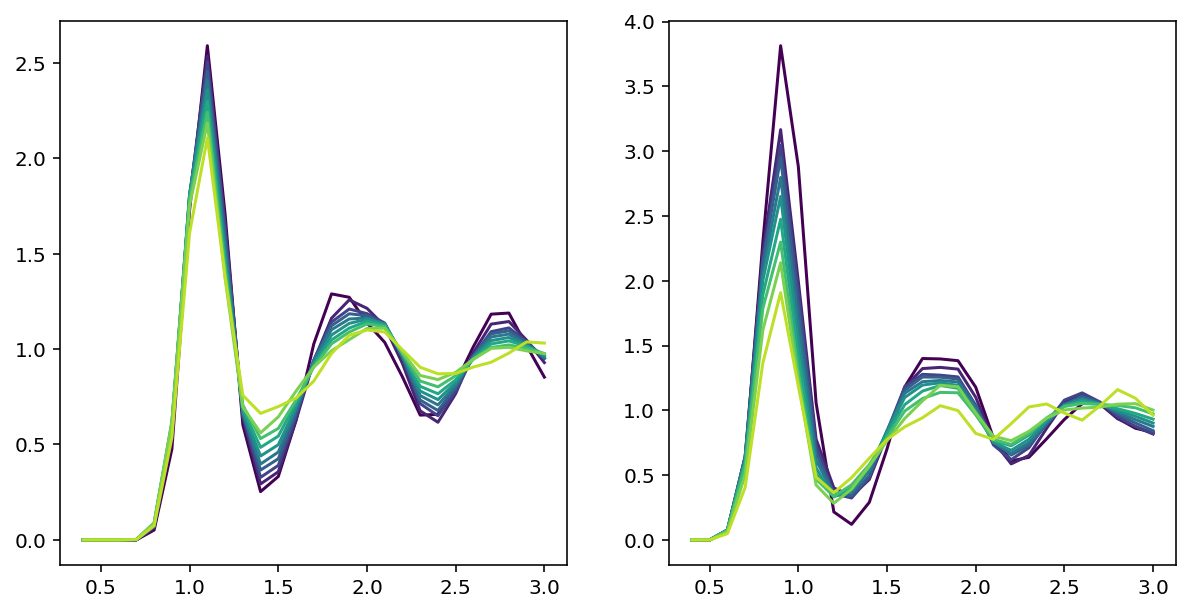

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

r = np.linspace(0.4, 3.0, 27)

cmap = cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=len(rdfs))
for idx, rdf in enumerate(rdfs):
    axs[0].plot(r, rdf[0], color=cmap(norm(idx)))
    axs[1].plot(r, rdf[1], color=cmap(norm(idx)))

In [90]:
len(rdfs[0])

52430

In [95]:
tdf.iloc[soft_groups[0]].sf.mean()

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 8.8456218e-06,
       0.0000000e+00, 2.1918766e-02, 2.0722256e-03, 2.4367937e-01,
       1.6185082e-01, 1.0431041e+00, 1.5287805e+00, 1.7788315e+00,
       5.7801533e+00, 1.3043472e+00, 9.2401276e+00, 5.7937485e-01,
       7.0277805e+00, 3.9634219e-01, 3.6241047e+00, 5.0175226e-01,
       2.6099391e+00, 8.3749330e-01, 3.4300549e+00, 1.5004864e+00,
       5.6390848e+00, 2.2838278e+00, 8.6048727e+00, 2.8005264e+00,
       1.1291640e+01, 3.1783473e+00, 1.3282088e+01, 3.4963574e+00,
       1.4850887e+01, 3.2277570e+00, 1.5939938e+01, 2.6693728e+00,
       1.4938492e+01, 2.6299133e+00, 1.2951655e+01, 3.2212403e+00,
       1.3226271e+01, 4.1966176e+00, 1.6312035e+01, 5.2184548e+00,
       2.0700048e+01, 5.9002843e+00, 2.4619125e+01, 6.1445799e+00,
       2.6871426e+01, 6.2116227e+00, 2.7528376e+01, 6.3076329e+00,
       2.7670399e+01, 6.3698549e+00], dtype=float32)

Simple monte carlo algorithm to find optimal partitioning doesn't work so well. How about standard clustering algos?

In [26]:
import scipy.stats as stats
import skopt

In [32]:
mat_ = np.stack(df.sf.to_numpy())

In [33]:
mat.shape

(235935, 54)

In [35]:
mat_cov = np.cov(mat.T)

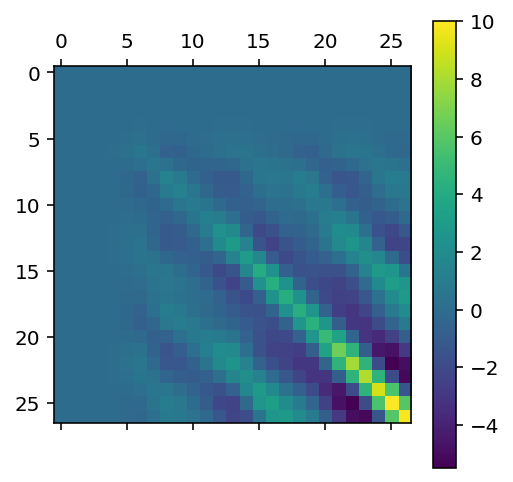

In [41]:
plt.matshow(mat_cov[::2, ::2])
plt.colorbar()

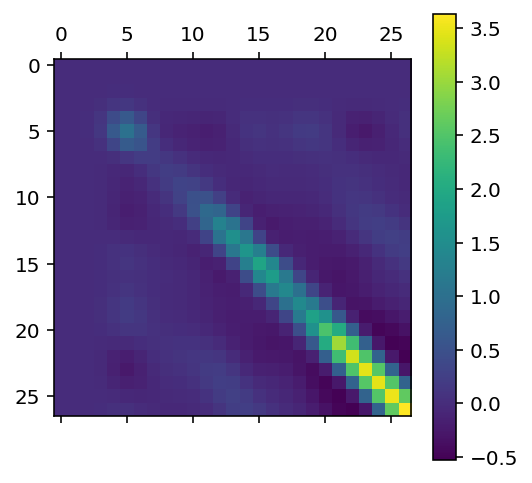

In [42]:
plt.matshow(mat_cov[1::2, 1::2])
plt.colorbar()

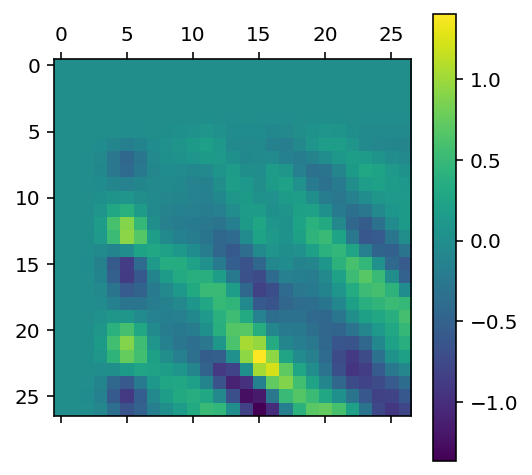

In [43]:
plt.matshow(mat_cov[::2, 1::2])
plt.colorbar()